## Track upwelled water using a step profile

I added two tracers, besides the original advetive tracer with linear profile, to track water upwelled through the canyon. One has a concentration of 1 below the shelf break depth and 0 above; the otherone has 0 below shelf break depth and 1 above, to track shelf water. 

These preliminary runs are under CNTDIFF_STEP. Run38 is the base case with canyon and run42 is the base case without a canyon. 

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

In [78]:
sns.set_style('dark')

In [65]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)

def BottomConc(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[BottomInd[i,j],i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotPool(ax,ConcFilt,xslice,yslice,colmap):
    
    BAC = ConcFilt[yslice,xslice]
    
    mesh = ax.contourf(X[xslice]/1000,Y[yslice]/1000,BAC,20, 
                      cmap=colmap, 
                      )
    
    SB = ax.contour(X[xslice]/1000,Y[yslice]/1000,
                    Depth[yslice,xslice],
                    [152.5],
                    colors='0.1',linewidths=[0.75] )
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    return(mesh)

In [2]:
# Grid, state and tracers datasets of base case
grid_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run38/gridGlob.nc'
state_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run38/stateGlob.nc' 
ptracers_file = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run38/ptracersGlob.nc'

#ptracers_fileNoC = '/data/kramosmu/results/TracerExperiments/CNTDIFF_STEP/run42/ptracersGlob.nc' 
# Still waiting for this run to finish on graham


In [12]:
with Dataset(grid_file, 'r') as nbl:
    Z = nbl.variables['RC'][:]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
    hFacC = nbl.variables['HFacC'][:]
    rA = nbl.variables['rA'][:]
    Depth = nbl.variables['Depth'][:]

hfac = np.ma.masked_values(hFacC, 0)
maskC = np.ma.getmask(hfac)
    
with Dataset(state_file, 'r') as nbl:
    iters = nbl.variables['iter'][:]

### Comparison of all 4 tracers at days 1, 4, 8

#### Canyon axis

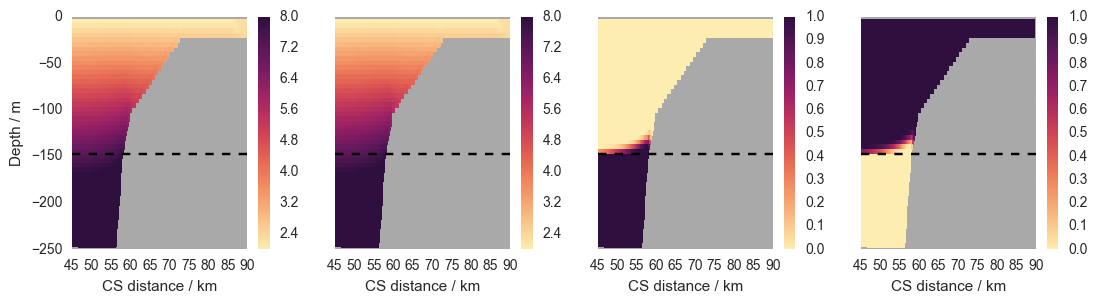

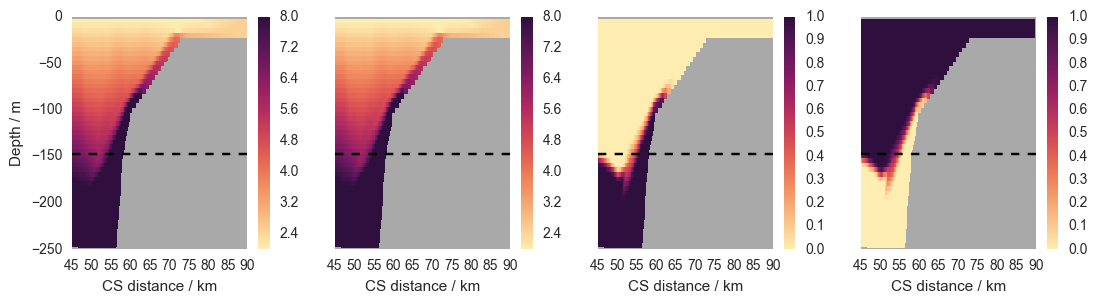

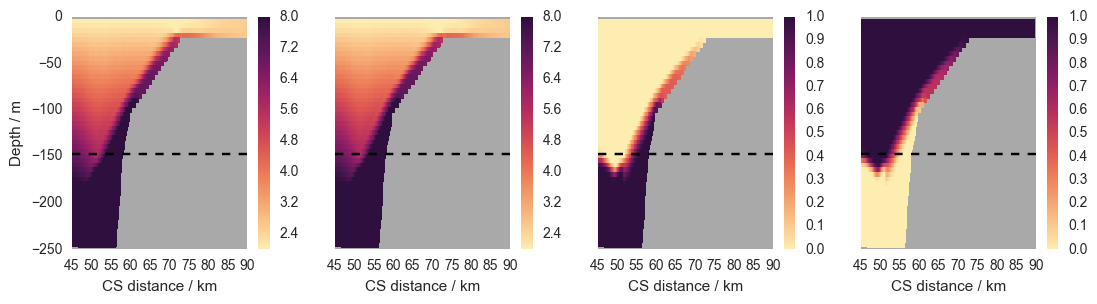

In [39]:
times = [2,8,16]
zslice = slice(0,50)
xslice = 180 # canyon axis
yslice = slice(180,360)


for tt in times:
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(13,3), sharey=True)
    for ax in [ax1,ax2,ax3,ax4]:
        ax.set_axis_bgcolor("darkgrey")
        ax.set_xlabel('CS distance / km')

    with Dataset(ptracers_file, 'r') as ptr:
        Tr1 = np.ma.masked_array(ptr.variables['Tr1'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr2 = np.ma.masked_array(ptr.variables['Tr2'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr3 = np.ma.masked_array(ptr.variables['Tr3'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr4 = np.ma.masked_array(ptr.variables['Tr4'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        
    pc1 = ax1.pcolor(Y[yslice]/1000,Z[zslice],Tr1, cmap=cmo.cm.matter, vmin=2, vmax=8)
    plt.colorbar(pc1, ax=ax1)
    pc2 = ax2.pcolor(Y[yslice]/1000,Z[zslice],Tr2, cmap=cmo.cm.matter, vmin=2, vmax=8)
    plt.colorbar(pc2, ax=ax2)
    pc3 = ax3.pcolor(Y[yslice]/1000,Z[zslice],Tr3, cmap=cmo.cm.matter, vmin=0, vmax=1)
    plt.colorbar(pc3, ax=ax3)
    pc4 = ax4.pcolor(Y[yslice]/1000,Z[zslice],Tr4, cmap=cmo.cm.matter, vmin=0, vmax=1)
    plt.colorbar(pc4, ax=ax4)
    
    for ax in [ax1,ax2,ax3,ax4]:
        ax.axhline(-147.5, linestyle='--', color='k')
    
    ax1.set_ylabel('Depth / m')
    
    

#### Downstream shelf

7.21757
7.21757
7.21757


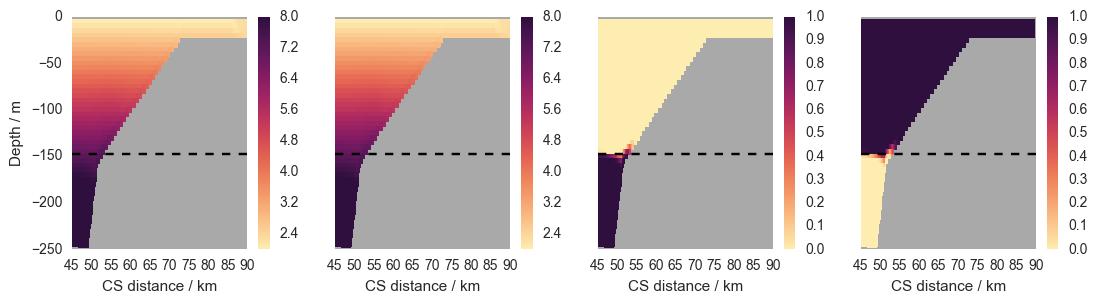

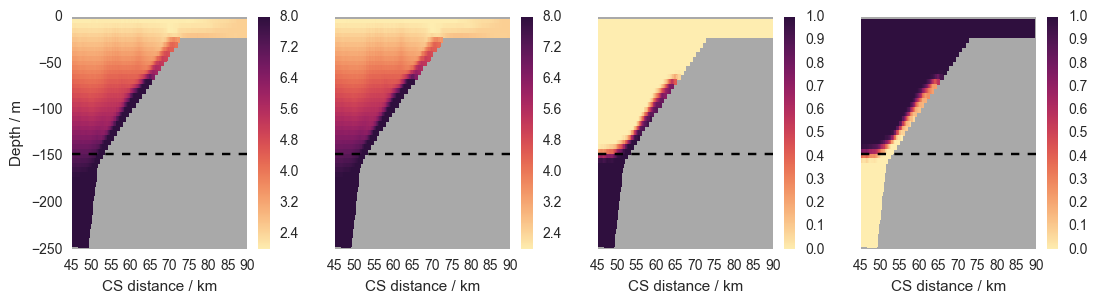

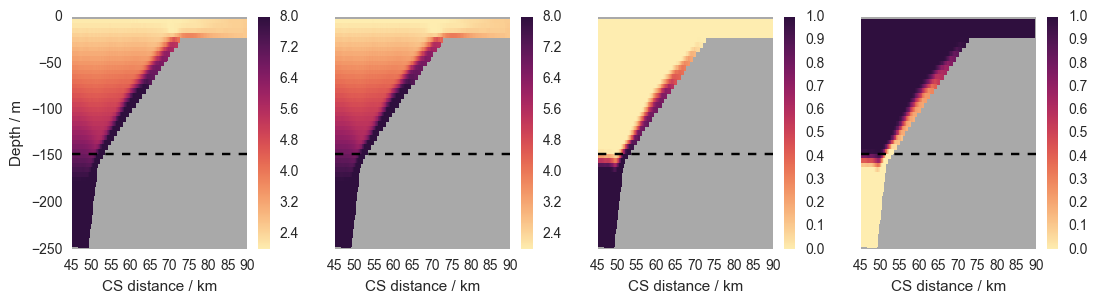

In [87]:
times = [2,8,16]
zslice = slice(0,50)
xslice = 240 # canyon axis
yslice = slice(180,360)

for tt in times:
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(13,3), sharey=True)
    for ax in [ax1,ax2,ax3,ax4]:
        ax.set_axis_bgcolor("darkgrey")
        ax.set_xlabel('CS distance / km')

    with Dataset(ptracers_file, 'r') as ptr:
        Tr1 = np.ma.masked_array(ptr.variables['Tr1'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr2 = np.ma.masked_array(ptr.variables['Tr2'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr3 = np.ma.masked_array(ptr.variables['Tr3'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        Tr4 = np.ma.masked_array(ptr.variables['Tr4'][tt,zslice,yslice,xslice], mask=maskC[zslice,yslice,xslice])
        
    pc1 = ax1.pcolor(Y[yslice]/1000,Z[zslice],Tr1, cmap=cmo.cm.matter, vmin=2, vmax=8)
    plt.colorbar(pc1, ax=ax1)
    pc2 = ax2.pcolor(Y[yslice]/1000,Z[zslice],Tr2, cmap=cmo.cm.matter, vmin=2, vmax=8)
    plt.colorbar(pc2, ax=ax2)
    pc3 = ax3.pcolor(Y[yslice]/1000,Z[zslice],Tr3, cmap=cmo.cm.matter, vmin=0, vmax=1)
    plt.colorbar(pc3, ax=ax3)
    pc4 = ax4.pcolor(Y[yslice]/1000,Z[zslice],Tr4, cmap=cmo.cm.matter, vmin=0, vmax=1)
    plt.colorbar(pc4, ax=ax4)
    
    for ax in [ax1,ax2,ax3,ax4]:
        ax.axhline(-147.5, linestyle='--', color='k')
    
    ax1.set_ylabel('Depth / m')
    
    

### Mean bottom concentration during advective phase

In [88]:
yslice_pl = slice(225,360)
xslice_pl = slice(120,500)

with Dataset(ptracers_file, 'r') as ptr:
    ConcAreaTr1, ConcTr1, AreaTr1 = BottomConc(np.mean(ptr.variables['Tr1'][8:18,:,:,:], axis=0),hFacC,rA,Depth)
    ConcAreaTr2, ConcTr2, AreaTr2 = BottomConc(np.mean(ptr.variables['Tr2'][8:18,:,:,:], axis=0),hFacC,rA,Depth)
    ConcAreaTr3, ConcTr3, AreaTr3 = BottomConc(np.mean(ptr.variables['Tr3'][8:18,:,:,:], axis=0),hFacC,rA,Depth)
    ConcAreaTr4, ConcTr4, AreaTr4 = BottomConc(np.mean(ptr.variables['Tr4'][8:18,:,:,:], axis=0),hFacC,rA,Depth)

/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


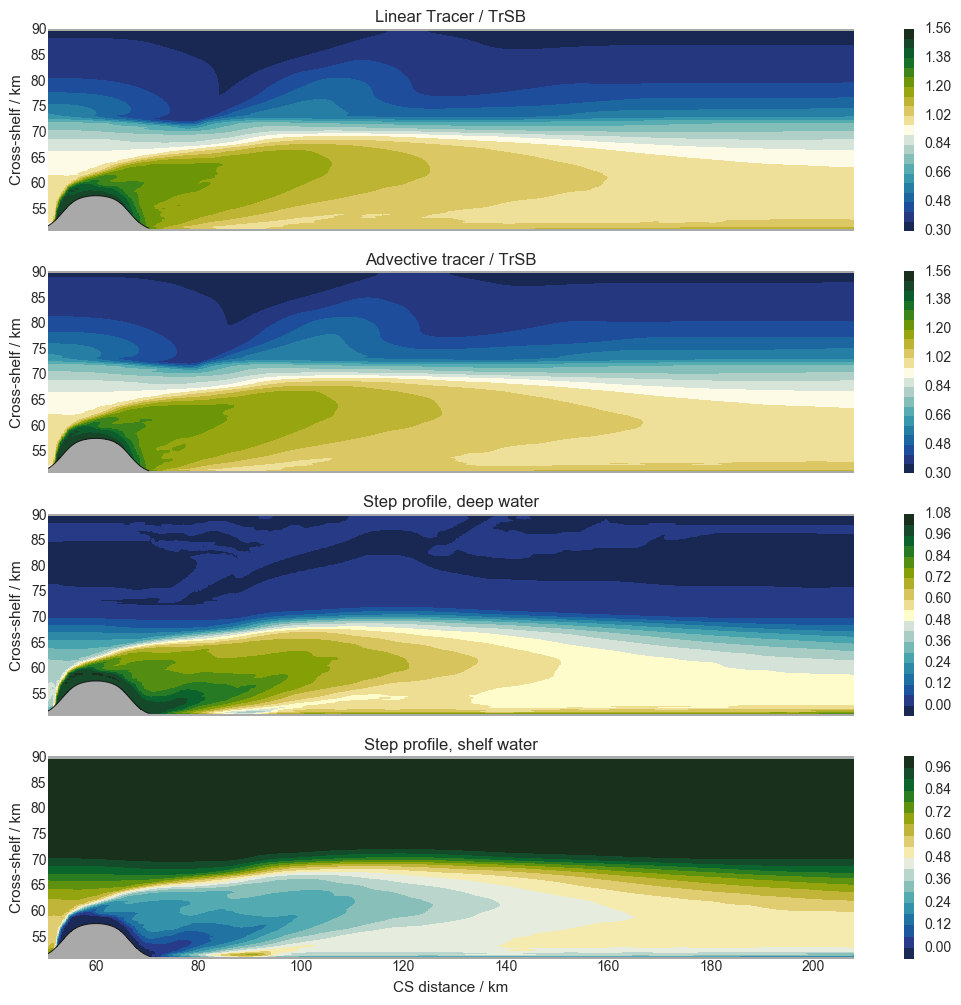

In [90]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(13,12), sharey=True, sharex = True)

mesh1 = PlotPool(ax1,ConcTr1/7.21,xslice_pl,yslice_pl, cmo.cm.delta)
mesh2 = PlotPool(ax2,ConcTr2/7.21,xslice_pl,yslice_pl, cmo.cm.delta)
mesh3 = PlotPool(ax3,ConcTr3,xslice_pl,yslice_pl, cmo.cm.delta)
mesh4 = PlotPool(ax4,ConcTr4,xslice_pl,yslice_pl, cmo.cm.delta)

plt.colorbar(mesh1, ax=ax1)
plt.colorbar(mesh2, ax=ax2)
plt.colorbar(mesh3, ax=ax3)
plt.colorbar(mesh4, ax=ax4)

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_axis_bgcolor("darkgrey")
    ax.set_ylabel('Cross-shelf / km')

ax4.set_xlabel('CS distance / km')
ax1.set_title('Linear Tracer / TrSB')
ax2.set_title('Advective tracer / TrSB')
ax3.set_title('Step profile, deep water')
ax4.set_title('Step profile, shelf water')